In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

import joblib 

In [2]:
df = pd.read_csv("data/synthetic_rul_v5.csv", sep=";", encoding="utf-8")
seq_len = 30  # adjustable
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df = df.sort_values(['equipment_id', 'timestamp']).copy()

In [6]:
"""
final_dfs = []
for eq in df['equipment_id'].unique():
    eq_df = df[df['equipment_id'] == eq].copy()
    failure_indices = eq_df[eq_df['failure_event'] == 1].index.tolist()

    if not failure_indices:
        print(failure_indices)
        continue

    failure_indices = sorted(failure_indices)

    # Build proper segments between failures
    starts = [eq_df.index.min()] + [idx + 1 for idx in failure_indices[:-1]]
    ends = failure_indices

    for start, end in zip(starts, ends):
        cycle_df = eq_df.loc[start:end].copy()
        cycle_df['RUL'] = np.arange(len(cycle_df)-1, 0-1, -1)
        final_dfs.append(cycle_df)

df = pd.concat(final_dfs).reset_index(drop=True)"""

"\nfinal_dfs = []\nfor eq in df['equipment_id'].unique():\n    eq_df = df[df['equipment_id'] == eq].copy()\n    failure_indices = eq_df[eq_df['failure_event'] == 1].index.tolist()\n\n    if not failure_indices:\n        print(failure_indices)\n        continue\n\n    failure_indices = sorted(failure_indices)\n\n    # Build proper segments between failures\n    starts = [eq_df.index.min()] + [idx + 1 for idx in failure_indices[:-1]]\n    ends = failure_indices\n\n    for start, end in zip(starts, ends):\n        cycle_df = eq_df.loc[start:end].copy()\n        cycle_df['RUL'] = np.arange(len(cycle_df)-1, 0-1, -1)\n        final_dfs.append(cycle_df)\n\ndf = pd.concat(final_dfs).reset_index(drop=True)"

In [3]:

print(df["RUL"].mean())
print(df["RUL"].min())
print(df["RUL"].max())
print(len(df[df["failure_event"]==1]))
print(len(df["RUL"].isna()))

df["RUL"].info()
df.head()

35.34642
0
99
726
50000
<class 'pandas.core.series.Series'>
RangeIndex: 50000 entries, 0 to 49999
Series name: RUL
Non-Null Count  Dtype
--------------  -----
50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


,timestamp,equipment_id,counter_value,temperature,vibration,pressure,operating_state,failure_event,RUL
0,2025-02-11 00:00:00,EQ-0001,1,19.965689,0.511584,3.993593,1,0,62
1,2025-02-11 01:00:00,EQ-0001,5,20.192926,0.518210,4.090053,1,0,61
2,2025-02-11 02:00:00,EQ-0001,12,20.601053,0.487282,4.036994,1,0,60
3,2025-02-11 03:00:00,EQ-0001,16,20.599435,0.536423,4.183201,1,0,59
4,2025-02-11 04:00:00,EQ-0001,22,20.296701,0.536608,4.196372,1,0,58


In [3]:
df = df.sort_values(['equipment_id', 'timestamp']).reset_index(drop=True)

# Convert sensor columns
sensor_cols = ['temperature', 'vibration', 'pressure']
for col in sensor_cols:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

In [4]:
# Feature engineering per equipment
rolling_window=3
for eq in df['equipment_id'].unique():
    eq_idx = df['equipment_id'] == eq
    eq_data = df.loc[eq_idx, sensor_cols]

    # Rolling mean
    roll_mean = eq_data.rolling(rolling_window, min_periods=1).mean()
    roll_mean.columns = [f'{c}_roll_mean' for c in sensor_cols]  # rename

    df.loc[eq_idx, roll_mean.columns] = roll_mean

    # Rolling std
    roll_std = eq_data.rolling(rolling_window, min_periods=1).std().fillna(0)
    roll_std.columns = [f'{c}_roll_std' for c in sensor_cols]  # rename

    df.loc[eq_idx, roll_std.columns] = roll_std

    # Lag features
    for lag in range(1, 4):
        lag_df = eq_data.shift(lag).fillna(0)
        lag_df.columns = [f'{c}_lag{lag}' for c in sensor_cols]  # rename
        df.loc[eq_idx, lag_df.columns] = lag_df

df['vibration_slope'] = df.groupby('equipment_id')['vibration_roll_mean'].transform(lambda x: x.diff().fillna(0))
df['vibration_min']   = df.groupby('equipment_id')['vibration_roll_mean'].transform(lambda x: x.rolling(24, min_periods=1).min())
df['vibration_max']   = df.groupby('equipment_id')['vibration_roll_mean'].transform(lambda x: x.rolling(24, min_periods=1).max())
df['vibration_std']   = df.groupby('equipment_id')['vibration_roll_mean'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))


In [35]:
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()

print(corr["RUL"].sort_values())

temperature             -0.795238
vibration               -0.792003
temperature_roll_mean   -0.763467
vibration_roll_mean     -0.762686
vibration_lag1          -0.721203
temperature_lag1        -0.713634
pressure_roll_mean      -0.712034
pressure                -0.711975
pressure_lag1           -0.663933
vibration_min           -0.663875
vibration_lag2          -0.655721
temperature_lag2        -0.642091
pressure_lag2           -0.622189
vibration_lag3          -0.595770
pressure_lag3           -0.584902
temperature_lag3        -0.578514
vibration_slope         -0.257832
failure_event           -0.191952
counter_value           -0.075925
vibration_max            0.089194
vibration_roll_std       0.246298
temperature_roll_std     0.252557
pressure_roll_std        0.280082
vibration_std            0.648145
RUL                      1.000000
operating_state               NaN
Name: RUL, dtype: float64


In [30]:
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()

print(corr["RUL"].sort_values())

temperature             -0.795238
vibration               -0.792003
temperature_roll_mean   -0.763467
vibration_roll_mean     -0.762686
vibration_lag1          -0.721203
temperature_lag1        -0.713634
pressure_roll_mean      -0.712034
pressure                -0.711975
pressure_lag1           -0.663933
vibration_min           -0.663875
vibration_lag2          -0.655721
temperature_lag2        -0.642091
pressure_lag2           -0.622189
vibration_lag3          -0.595770
pressure_lag3           -0.584902
temperature_lag3        -0.578514
vibration_slope         -0.257832
failure_event           -0.191952
counter_value           -0.075925
vibration_max            0.089194
vibration_roll_std       0.246298
temperature_roll_std     0.252557
pressure_roll_std        0.280082
vibration_std            0.648145
RUL                      1.000000
operating_state               NaN
Name: RUL, dtype: float64


In [5]:
# Define final features
"""engineered_features = ['temperature','vibration','pressure','operating_state']
engineered_features = [ 'temperature','vibration','pressure','operating_state', 'vibration_roll_mean', 'vibration_lag1', 'vibration_lag2','vibration_lag3']
engineered_features = [
    'temperature', 'vibration', 'pressure', 
    'vibration_roll_mean', 'vibration_lag1', 'vibration_lag2', 'vibration_lag3',
    'vibration_slope', 'vibration_min', 'vibration_max', 'vibration_std'
]
engineered_features = sensor_cols + \
                        [f'{c}_roll_mean' for c in sensor_cols] + \
                        [f'{c}_roll_std' for c in sensor_cols] + \
                        [f'{c}_lag{l}' for c in sensor_cols for l in range(1,4)] + \
                        ['operating_state']"""

engineered_features = ['temperature','vibration','temperature_roll_mean',
                       'vibration_roll_mean','temperature_lag1','vibration_lag1',
                       'pressure_roll_mean','pressure','pressure_lag1','temperature_lag2',
                       'vibration_lag2','pressure_lag2','vibration_min','pressure_lag3',
                       'temperature_lag3','vibration_lag3','failure_event']
engineered_features = [
    # Raw signals
    'temperature', 'vibration', 'pressure',

    # Rolling means (short-term smoothing)
    'temperature_roll_mean', 'vibration_roll_mean', 'pressure_roll_mean',

    # Lag features (temporal dependencies)
    'temperature_lag1', 'vibration_lag1', 'pressure_lag1',
    'temperature_lag2', 'vibration_lag2', 'pressure_lag2',
    'temperature_lag3', 'vibration_lag3', 'pressure_lag3',

    # Variability (very predictive for failures)
    'temperature_roll_std', 'vibration_roll_std', 'pressure_roll_std',

    # Long-window degradation indicators
    'vibration_min', 'vibration_max', 'vibration_std', 'vibration_slope',

    # Events
    'failure_event'
]


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              50000 non-null  datetime64[ns]
 1   equipment_id           50000 non-null  object        
 2   counter_value          50000 non-null  int64         
 3   temperature            50000 non-null  float64       
 4   vibration              50000 non-null  float64       
 5   pressure               50000 non-null  float64       
 6   operating_state        50000 non-null  int64         
 7   failure_event          50000 non-null  int64         
 8   RUL                    50000 non-null  int64         
 9   temperature_roll_mean  50000 non-null  float64       
 10  vibration_roll_mean    50000 non-null  float64       
 11  pressure_roll_mean     50000 non-null  float64       
 12  temperature_roll_std   50000 non-null  float64       
 13  v

count    50000.000000
mean        35.346420
std         22.352057
min          0.000000
25%         17.000000
50%         34.000000
75%         51.000000
max         99.000000
Name: RUL, dtype: float64


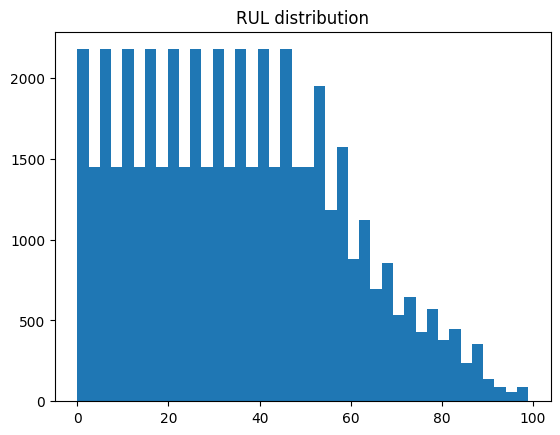

In [39]:
print(df['RUL'].describe())
plt.hist(df['RUL'],  bins=40,)
plt.title('RUL distribution')
plt.show()

In [6]:
df = df.sort_values(['equipment_id', 'timestamp']).reset_index(drop=True)

X, y = [], []
for eq in df['equipment_id'].unique():
    eq_data = df[df['equipment_id'] == eq][engineered_features].values
    rul = df[df['equipment_id'] == eq]['RUL'].values
    if len(eq_data) <= seq_len:
        continue
    split_idx = int(len(eq_data) * 0.8)  # 80% train, 20% val per equipment
     # Training sequences
    for i in range(split_idx - seq_len):
        X.append(eq_data[i:i+seq_len])
        y.append(rul[i+seq_len-1])
X_train = np.array(X)
y_train = np.array(y)

X_val, y_val = [], []
for eq in df['equipment_id'].unique():
    eq_data = df[df['equipment_id'] == eq][engineered_features].values
    rul = df[df['equipment_id'] == eq]['RUL'].values
    if len(eq_data) <= seq_len:
        continue

    split_idx = int(len(eq_data) * 0.8)
    for i in range(split_idx, len(eq_data) - seq_len):
        X_val.append(eq_data[i:i+seq_len])
        y_val.append(rul[i+seq_len-1])
X_val = np.array(X_val)
y_val = np.array(y_val)


# Scale features (fit on training data only)
num_samples, seq_len, num_features = X_train.shape
X_train_2d = X_train.reshape(num_samples * seq_len, num_features)
scaler = StandardScaler()
X_train_2d = scaler.fit_transform(X_train_2d)
X_train = X_train_2d.reshape(num_samples, seq_len, num_features)
joblib.dump(scaler, 'scaler.save')

X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Scale validation data
num_val_samples = X_val.shape[0]
X_val_2d = X_val.reshape(num_val_samples * seq_len, num_features)
X_val_2d = scaler.transform(X_val_2d)
X_val = X_val_2d.reshape(num_val_samples, seq_len, num_features)

In [7]:
model = Sequential([
        LSTM(128, return_sequences=True),
        LSTM(64, return_sequences=True),
        Dropout(0.1),
        LSTM(32),
        Dropout(0.1),
        Dense(1)
    ])
model.compile(optimizer='adam', loss='mse')

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)
model.save('rul_lstm_model.keras')

Epoch 1/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 477.5485 - val_loss: 70.3498
Epoch 2/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - loss: 42.7894 - val_loss: 8.8336
Epoch 3/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - loss: 15.5595 - val_loss: 4.8272
Epoch 4/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 11.2437 - val_loss: 3.0576
Epoch 5/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 10.1386 - val_loss: 3.2331
Epoch 6/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 9.5481 - val_loss: 3.0247
Epoch 7/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 9.2491 - val_loss: 3.2677
Epoch 8/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - loss: 8.7920 - val_loss: 3.1849
Epoch 9/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 9.3109 - val_loss: 3.1159
Epoch 10/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 8.4332 - val_loss: 2.5801
Epoch 11/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - loss: 8.1054 - val_loss: 3.8315
E

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)
model.save('rul_lstm_model.keras')

Epoch 1/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 531.3588 - val_loss: 94.7936
Epoch 2/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 52.0036 - val_loss: 20.1547
Epoch 3/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 18.2145 - val_loss: 9.2572
Epoch 4/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 13.5300 - val_loss: 5.9768
Epoch 5/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 12.5043 - val_loss: 4.8687
Epoch 6/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 11.6731 - val_loss: 5.8522
Epoch 7/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - loss: 11.4595 - val_loss: 5.4172
Epoch 8/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - loss: 11.1277 - val_loss: 5.1503
Epoch 9/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - loss: 10.8544 - val_loss: 4.9798
Epoch 10/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 696s 289ms/step - loss: 10.4562 - val_loss: 4.9917


In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)
model.save('rul_lstm_model.keras')

Epoch 1/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 518.6044 - val_loss: 84.6708
Epoch 2/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 50.2273 - val_loss: 12.2561
Epoch 3/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 18.4811 - val_loss: 6.6321
Epoch 4/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 13.5103 - val_loss: 6.3305
Epoch 5/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 12.3936 - val_loss: 5.7864
Epoch 6/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 11.9955 - val_loss: 5.7235
Epoch 7/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 11.4780 - val_loss: 5.7549
Epoch 8/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 11.2195 - val_loss: 4.9030
Epoch 9/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 10.7311 - val_loss: 5.4918
Epoch 10/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - loss: 10.4445 - val_loss: 4.7387
Epoch 11/20
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - loss: 10.3938 - val_loss: 5

In [9]:
# Best metric reached yet, cant improve further with such uncorrelated data goodbye.
#  5. Compute metrics drpout 0.1 seq 24 rolling window 3 Reduce features 4 cal featrues +vib +temp +pres+'vibration_roll_mean', 'vibration_lag1', 'vibration_lag2','vibration_lag3' + shuffles
y_pred = model.predict(X_val, verbose=0).flatten()
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 2.37
RMSE: 1.54
MAE: 1.12
R²: 0.99


In [23]:
# Best metric reached yet, cant improve further with such uncorrelated data goodbye.
#  5. Compute metrics drpout 0.1 seq 24 rolling window 3 Reduce features 4 cal featrues +vib +temp +pres+'vibration_roll_mean', 'vibration_lag1', 'vibration_lag2','vibration_lag3' + shuffles
y_pred = model.predict(X_val, verbose=0).flatten()
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 4.87
RMSE: 2.21
MAE: 1.57
R²: 0.99


In [24]:
# Best metric reached yet, cant improve further with such uncorrelated data goodbye.
#  5. Compute metrics drpout 0.1 seq 24 rolling window 3 Reduce features 4 cal featrues +vib +temp +pres+'vibration_roll_mean', 'vibration_lag1', 'vibration_lag2','vibration_lag3' + shuffles
y_pred = model.predict(X_val, verbose=0).flatten()
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 4.72
RMSE: 2.17
MAE: 1.46
R²: 0.99


In [2]:
def predict_rul(new_df, engineered_features, seq_len):

    model = load_model('model/rul_lstm_model_v2.keras')
    scaler = joblib.load('model/scaler_v2.save')

    sensor_cols = ['temperature', 'vibration', 'pressure']

    for col in sensor_cols:
        new_df[col] = (
            new_df[col]
            .astype(str)
            .str.replace(',', '.', regex=False)
            .astype(float)
        )


    if "failure_event" not in new_df.columns:
        new_df["failure_event"] = 0

    for eq in new_df['equipment_id'].unique():
        eq_idx = new_df['equipment_id'] == eq
        eq_data = new_df.loc[eq_idx, sensor_cols]

        # Rolling mean
        roll_mean = eq_data.rolling(3, min_periods=1).mean()
        for c in sensor_cols:
            new_df.loc[eq_idx, f"{c}_roll_mean"] = roll_mean[c]

        # Rolling std
        roll_std = eq_data.rolling(3, min_periods=1).std().fillna(0)
        for c in sensor_cols:
            new_df.loc[eq_idx, f"{c}_roll_std"] = roll_std[c]

        # Lags: 1, 2, 3
        for lag in range(1, 4):
            for c in sensor_cols:
                new_df.loc[eq_idx, f"{c}_lag{lag}"] = eq_data[c].shift(lag).bfill()

        # 24-step rolling stats for vibration_roll_mean
        if "vibration_roll_mean" in new_df.columns:
            vr = new_df.loc[eq_idx, "vibration_roll_mean"]
            new_df.loc[eq_idx, "vibration_slope"] = vr.diff().fillna(0)
            new_df.loc[eq_idx, "vibration_min"] = vr.rolling(24, min_periods=1).min()
            new_df.loc[eq_idx, "vibration_max"] = vr.rolling(24, min_periods=1).max()
            new_df.loc[eq_idx, "vibration_std"] = vr.rolling(24, min_periods=1).std().fillna(0)

    missing = [c for c in engineered_features if c not in new_df.columns]
    if missing:
        raise ValueError(f"Missing required features: {missing}")

    to_scale = new_df[engineered_features].copy()


    to_scale = scaler.transform(to_scale)
    new_df[engineered_features] = to_scale


    predictions = {}
    for eq in new_df['equipment_id'].unique():
        eq_data = new_df[new_df['equipment_id'] == eq][engineered_features].values

        if len(eq_data) < seq_len:
            raise ValueError(
                f"Equipment {eq} has only {len(eq_data)} rows, but {seq_len} required."
            )

        seq = eq_data[-seq_len:].reshape(1, seq_len, len(engineered_features))
        rul_pred = float(model.predict(seq, verbose=0)[0][0])
        predictions[eq] = rul_pred

    return predictions


In [11]:
data = [
  
  {"equipment_id": 1, "timestamp": "2026-01-01T00:00:00", "temperature": 45.12, "vibration": 1.23, "pressure": 5.67, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T01:00:00", "temperature": 46.87, "vibration": 1.45, "pressure": 5.89, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T02:00:00", "temperature": 44.33, "vibration": 1.12, "pressure": 6.01, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T03:00:00", "temperature": 47.56, "vibration": 1.34, "pressure": 5.78, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T04:00:00", "temperature": 45.99, "vibration": 1.56, "pressure": 5.92, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T05:00:00", "temperature": 46.21, "vibration": 1.28, "pressure": 6.11, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T06:00:00", "temperature": 45.44, "vibration": 1.47, "pressure": 5.85, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T07:00:00", "temperature": 46.78, "vibration": 1.39, "pressure": 6.02, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T08:00:00", "temperature": 45.66, "vibration": 1.24, "pressure": 5.96, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T09:00:00", "temperature": 46.12, "vibration": 1.51, "pressure": 5.88, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T10:00:00", "temperature": 45.87, "vibration": 1.33, "pressure": 6.03, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T11:00:00", "temperature": 46.54, "vibration": 1.29, "pressure": 5.90, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T12:00:00", "temperature": 45.75, "vibration": 1.42, "pressure": 5.97, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T13:00:00", "temperature": 46.31, "vibration": 1.36, "pressure": 6.05, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T14:00:00", "temperature": 45.92, "vibration": 1.40, "pressure": 5.99, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T15:00:00", "temperature": 46.20, "vibration": 1.31, "pressure": 5.91, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T16:00:00", "temperature": 45.83, "vibration": 1.48, "pressure": 6.04, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T17:00:00", "temperature": 46.11, "vibration": 1.37, "pressure": 5.86, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T18:00:00", "temperature": 45.95, "vibration": 1.45, "pressure": 5.93, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T19:00:00", "temperature": 46.03, "vibration": 1.30, "pressure": 5.87, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T20:00:00", "temperature": 45.88, "vibration": 1.41, "pressure": 6.00, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T21:00:00", "temperature": 46.55, "vibration": 1.38, "pressure": 5.94, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T22:00:00", "temperature": 45.93, "vibration": 1.27, "pressure": 5.90, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-01T23:00:00", "temperature": 46.42, "vibration": 1.49, "pressure": 6.01, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-02T00:00:00", "temperature": 45.70, "vibration": 1.35, "pressure": 5.89, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-02T01:00:00", "temperature": 46.18, "vibration": 1.43, "pressure": 5.92, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-02T02:00:00", "temperature": 45.99, "vibration": 1.32, "pressure": 6.04, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-02T03:00:00", "temperature": 46.27, "vibration": 1.44, "pressure": 5.95, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-02T04:00:00", "temperature": 45.84, "vibration": 1.39, "pressure": 5.97, "failure_event": 0},
  {"equipment_id": 1, "timestamp": "2026-01-02T05:00:00", "temperature": 46.00, "vibration": 1.35, "pressure": 5.95, "failure_event": 0},

  {"equipment_id": 2, "timestamp": "2026-01-01T00:00:00", "temperature": 44.78, "vibration": 1.11, "pressure": 5.70, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T01:00:00", "temperature": 45.96, "vibration": 1.22, "pressure": 5.83, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T02:00:00", "temperature": 44.21, "vibration": 1.08, "pressure": 5.99, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T03:00:00", "temperature": 45.67, "vibration": 1.15, "pressure": 5.76, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T04:00:00", "temperature": 44.83, "vibration": 1.19, "pressure": 5.86, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T05:00:00", "temperature": 45.44, "vibration": 1.14, "pressure": 6.00, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T06:00:00", "temperature": 44.91, "vibration": 1.23, "pressure": 5.95, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T07:00:00", "temperature": 45.58, "vibration": 1.21, "pressure": 5.92, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T08:00:00", "temperature": 44.75, "vibration": 1.09, "pressure": 5.88, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T09:00:00", "temperature": 45.36, "vibration": 1.20, "pressure": 6.02, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T10:00:00", "temperature": 44.98, "vibration": 1.13, "pressure": 5.90, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T11:00:00", "temperature": 45.41, "vibration": 1.17, "pressure": 5.94, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T12:00:00", "temperature": 44.89, "vibration": 1.16, "pressure": 5.91, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T13:00:00", "temperature": 45.62, "vibration": 1.24, "pressure": 6.03, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T14:00:00", "temperature": 44.82, "vibration": 1.12, "pressure": 5.93, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T15:00:00", "temperature": 45.27, "vibration": 1.18, "pressure": 5.89, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T16:00:00", "temperature": 44.95, "vibration": 1.10, "pressure": 5.87, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T17:00:00", "temperature": 45.30, "vibration": 1.23, "pressure": 5.98, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T18:00:00", "temperature": 44.88, "vibration": 1.11, "pressure": 6.01, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T19:00:00", "temperature": 45.51, "vibration": 1.26, "pressure": 5.96, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T20:00:00", "temperature": 44.93, "vibration": 1.15, "pressure": 5.92, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T21:00:00", "temperature": 45.38, "vibration": 1.19, "pressure": 5.88, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T22:00:00", "temperature": 44.90, "vibration": 1.09, "pressure": 5.90, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-01T23:00:00", "temperature": 45.47, "vibration": 1.25, "pressure": 5.99, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-02T00:00:00", "temperature": 44.84, "vibration": 1.16, "pressure": 5.95, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-02T01:00:00", "temperature": 45.20, "vibration": 1.21, "pressure": 6.04, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-02T02:00:00", "temperature": 44.97, "vibration": 1.14, "pressure": 5.98, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-02T03:00:00", "temperature": 45.33, "vibration": 1.20, "pressure": 5.90, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-02T04:00:00", "temperature": 44.92, "vibration": 1.11, "pressure": 6.02, "failure_event": 0},
  {"equipment_id": 2, "timestamp": "2026-01-02T05:00:00", "temperature": 45.00, "vibration": 1.20, "pressure": 6.00, "failure_event": 0}

]


sample = pd.DataFrame(data)



In [12]:
sample.head()

,equipment_id,timestamp,temperature,vibration,pressure,failure_event
0,1,2026-01-01T00:00:00,45.12,1.23,5.67,0
1,1,2026-01-01T01:00:00,46.87,1.45,5.89,0
2,1,2026-01-01T02:00:00,44.33,1.12,6.01,0
3,1,2026-01-01T03:00:00,47.56,1.34,5.78,0
4,1,2026-01-01T04:00:00,45.99,1.56,5.92,0


In [13]:
predict_rul(sample, engineered_features, seq_len=30)

c:\Users\ASUS-02\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


{np.int64(1): 2.4037575721740723, np.int64(2): 2.194673776626587}

In [10]:
predict_rul(sample, engineered_features, seq_len=30)

c:\Users\ASUS-02\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


{np.int64(1): 2.288344621658325}

In [ ]:


predict_rul(sample, engineered_features, seq_len=30)

c:\Users\ASUS-02\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


{np.int64(1): 3.4975407123565674}